<font size="8" color="#61677A"><b>Проект: Промышленность</b></font>

# Содержание проекта

1. [Cодержание проекта](#Содержание-проекта)
2. [Описание проекта](#Описание-проекта)<br>

**Часть 1: План работы**

3. [Загрузка данных](#Загрузка-данных)
4. [Исследовательский анализ данных](#Исследовательский-анализ-данных) <br>
    4.1. [Данные об электродах](#Данные-об-электродах) <br>
    4.2. [Результаты измерений температуры](#Результаты-измерений-температуры) <br>
    4.3. [Данные о подаче сыпучих материалов](#Данные-о-подаче-сыпучих-материалов) <br>
    4.4. [Данные о подаче проволочных материалов](#Данные-о-подаче-проволочных-материалов) <br>
    4.5. [Данные о продувке сплава газом](#Данные-о-продувке-сплава-газом) <br>
    4.6. [Промежуточный вывод](#Промежуточный-вывод) <br>

**Часть 2: Код решения**

5. [Объединение таблиц](#Объединение-таблиц)
6. [Исследовательский анализ объединенных данных](#Исследовательский-анализ-объединенных-данных)
7. [Подготовка обучающей и тестовой выборок](#Подготовка-обучающей-и-тестовой-выборок)
8. [Обучение моделей](#Обучение-моделей) <br>
    8.1. [Линейная регрессия](#Линейная-регрессия)<br>
    8.2. [Случайный лес](#Случайный-лес)<br>
    8.3. [Градиентный бустинг](#Градиентный-бустинг)<br>
    8.4. [Стекинг](#Стекинг)<br>
    8.5. [Промежуточный вывод](#Промежуточный-вывод)<br>
9. [Тестирование лучшей модели](#Тестирование-лучшей-модели)
10. [Вывод по второй части работы](#Вывод-по-второй-части-работы)

**Часть 3: Отчет**

# Описание проекта

**Цель проекта**: построить модель, которая предскажет температуру стали после этапа легирования.

Легирование (добавление различных материалов) стали проводится для изменения ее химического состава. Сам процесс состоит из следующих этапов:
1. измерение температуры стали, проведение химического анализа
2. повышение температуры стали графитовыми электродами
3. добавление легирующих материалов
4. продувка стали инертным газом

Этот процесс итеративный, этапы повторяются пока не будет достигнут целевой химический состав и оптимальная температура плавки.

Для выполнения проекта могут быть использованы следующие данные:

|название файла| описание данных|
|---|---|
|data_arc_new.csv | данные об электродах|
|data_bulk_new.csv | данные об объеме подачи сыпучих материалов|
|data_bulk_time_new.csv | данные о времени подачи сыпучих материалов|
|data_gas_new.csv | данные о продувке сплава газом|
|data_temp_new.csv | результаты измерения температуры|
|data_wire_new.csv | данные об объеме подачи проволочных материалов|
|data_wire_time_new.csv | данные о времени подачи проволочных материалов|

В **задачи** проекта входят:
- проведение исследовательского анализа данных до объединения таблиц
- составление плана работы
- объединение данных из таблиц в один датафрейм
- исследовательский анализ данных после объединения таблиц
- построение моделей
- тестирование лучшей модели
- написание отчета

<font size="6" color="#61677A"><b>Часть 1: План работы</b></font>

# Загрузка данных

In [1]:
# импортируем необходимые библиотеки
import os
import pandas as pd
import numpy as np
from scipy.stats import normaltest

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, PredictionErrorDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# задаем параметры по умолчанию
sns.set(style='darkgrid')
RANDOM_STATE = 280823

In [3]:
# загружаем данные
try:
    os.chdir('/datasets')
except:
    os.chdir('./datasets')
    
electrode_df   = pd.read_csv('data_arc_new.csv')
temperature_df = pd.read_csv('data_temp_new.csv')
bulk_time_df   = pd.read_csv('data_bulk_time_new.csv', index_col=0)
bulk_df        = pd.read_csv('data_bulk_new.csv', index_col=0)
gas_df         = pd.read_csv('data_gas_new.csv', index_col=0)
wire_time_df   = pd.read_csv('data_wire_time_new.csv', index_col=0)
wire_df        = pd.read_csv('data_wire_new.csv', index_col=0)

# Исследовательский анализ данных

## Данные об электродах

In [4]:
# знакомимся с данными
electrode_df.head(15)

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0     1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1     1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2     1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3     1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4     1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   
5     2  2019-05-03 11:34:14  2019-05-03 11:36:31           0.381124   
6     2  2019-05-03 11:38:50  2019-05-03 11:44:28           0.261665   
7     2  2019-05-03 11:46:19  2019-05-03 11:48:25           0.710297   
8     2  2019-05-03 11:49:48  2019-05-03 11:53:18           0.786322   
9     3  2019-05-03 12:06:54  2019-05-03 12:11:34           1.101678   
10    3  2019-05-03 12:13:52  2019-05-03 12:15:56           0.542675   
11    3  2019-05-03 12:18:56  2019-05-03 12:20:45           0.774632   
12    3  2019-05-03 12:25:43  2019-05-03 12:27:00           1.222963   
13    3  2019-05-03 12:31:14  2019-05-03 12:32:19           0.421693   
14    4  2019-05-03 12:39:37  2019-05-03 12:43:04           0.642946   

    Реактивная мощность  
0              0.211253  
1              0.477438  
2              0.430460  
3              0.379979  
4              0.643691  
5              0.220351  
6              0.205527  
7              0.484962  
8              0.542517  
9              0.820856  
10             0.474673  
11             0.505690  
12             0.863676  
13             0.272562  
14             0.516071

Столбец `key` хранит номер партии. Для каждой партии количество нагревов может отличаться.

In [5]:
# приведем названия колонок к питоновскому стилю
electrode_df = electrode_df.rename(
    columns={
        'Начало нагрева дугой': 'start_heating',
        'Конец нагрева дугой':  'end_heating',
        'Активная мощность':    'active_power',
        'Реактивная мощность':  'reactive_power',
    }
)

In [6]:
# выведем основную информацию о датасете
electrode_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   start_heating   14876 non-null  object 
 2   end_heating     14876 non-null  object 
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [7]:
# преобразуем тип данных в колонках с датами и временем к datetime
electrode_df.start_heating = pd.to_datetime(electrode_df.start_heating)
electrode_df.end_heating   = pd.to_datetime(electrode_df.end_heating)

# добавим колонку с временем нагрева
electrode_df['heating_time'] = (electrode_df.end_heating - electrode_df.start_heating).dt.total_seconds()

In [8]:
# выведем преобразованный датасет
electrode_df.head()

key       start_heating         end_heating  active_power  reactive_power  \
0    1 2019-05-03 11:02:14 2019-05-03 11:06:02      0.305130        0.211253   
1    1 2019-05-03 11:07:28 2019-05-03 11:10:33      0.765658        0.477438   
2    1 2019-05-03 11:11:44 2019-05-03 11:14:36      0.580313        0.430460   
3    1 2019-05-03 11:18:14 2019-05-03 11:24:19      0.518496        0.379979   
4    1 2019-05-03 11:26:09 2019-05-03 11:28:37      0.867133        0.643691   

   heating_time  
0         228.0  
1         185.0  
2         172.0  
3         365.0  
4         148.0

In [9]:
# проверим наличие пропусков
electrode_df.isna().sum()

key               0
start_heating     0
end_heating       0
active_power      0
reactive_power    0
heating_time      0
dtype: int64

In [10]:
# выведем основную описательную статистику
electrode_df.describe(exclude='datetime')

key  active_power  reactive_power  heating_time
count  14876.000000  14876.000000    14876.000000  14876.000000
mean    1615.220422      0.662752        0.438986    171.670946
std      934.571502      0.258885        5.873485     98.186803
min        1.000000      0.223120     -715.479924     11.000000
25%      806.000000      0.467115        0.337175    107.000000
50%     1617.000000      0.599587        0.441639    147.000000
75%     2429.000000      0.830070        0.608201    214.000000
max     3241.000000      1.463773        1.270284    907.000000

В колонке `reactive_power` указано, что минимальное значение сильно отрицательное. Это явно указывает на наличие выброса. Посмотрим сколько выбросов такого рода имеется.

In [11]:
electrode_df[electrode_df['reactive_power'] < 0]

key       start_heating         end_heating  active_power  \
9780  2116 2019-07-28 02:22:08 2019-07-28 02:23:57      0.705344   

      reactive_power  heating_time  
9780     -715.479924         109.0

Всего одна запись. При построении графиков данную запись исключим из рассмотрения.

In [12]:
# построим распределение значений для чиселенных переменных (без key)
plt.figure(figsize=(14, 4.5))
df = electrode_df.drop(9780).copy()

for col in range(1, 4):
    plt.subplot(1, 3, col)
    sns.kdeplot(df.iloc[:, 2+col], fill=True);
    
plt.suptitle('Распределения значений для численных переменных');

In [13]:
def plot_corr_heatmap(coeff, title):
    """
    Функция для отрисовки матрицы корреляции с использованием тепловой карты.
    
    coeff: pd.DataFrame, корреляционная матрица
    title: str, название графика
    """
    ax = sns.heatmap(
        coeff,
        annot=True,                           # добавляем численные значения в каждую ячейку 
        fmt='.2f',                            
        mask=np.triu(np.ones_like(coeff)),    # отображаем только нижний треугольник матрицы
        cmap='coolwarm',                      # выбираем цветовую палитру
        cbar=False,                           # отключаем полосу цвета
        xticklabels=coeff.columns[:-1],              # устанавливаем подписи, убираем последнюю
        yticklabels=coeff.columns[1:].insert(0, ''), # устанавливаем подписи, скрываем первую
        linewidths=1,
    )
    ax.set_facecolor('white')                  # устанавливаем цвет фона

    plt.tick_params(bottom=False, left=False)  # отключаем отображение засечек
    plt.title(title, y=0.9, font=dict(size=15, family='sans-serif'))

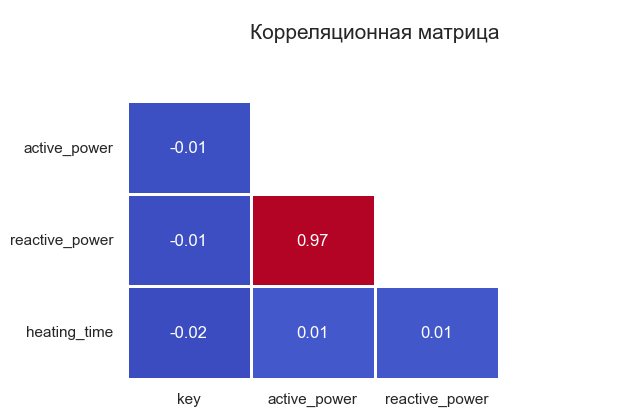

In [14]:
plot_corr_heatmap(df.corr(numeric_only=True), 'Корреляционная матрица')

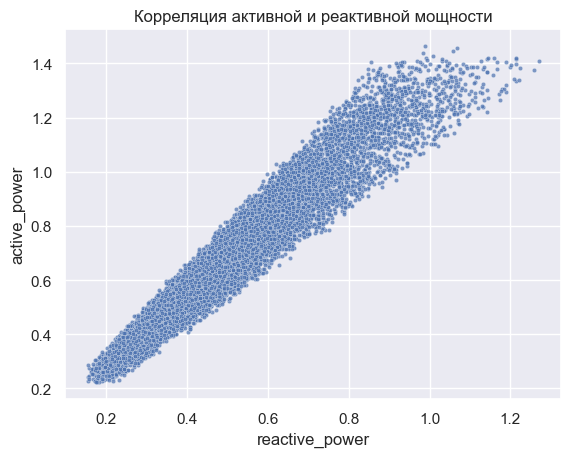

In [15]:
# построим зависимость активной мощности от реактивной
sns.scatterplot(x='reactive_power', y='active_power', data=df, alpha=0.7, s=10)
plt.title('Корреляция активной и реактивной мощности');

*Активная мощность* - полезная часть мощности, питающая нагрузку постоянного тока.<br>
*Реактивная мощность* - бесполезная мощность, перетекающая от источника к нагрузке и обратно.
- активная и реактивная мощности сильно коррелируют (что не удивительно). Вместо них можно использовать полную мощность, которая равняется корню из суммы квадратов активной и реактивной мощностей
- среднее значение активной мощности всего лишь на 0.2 больше реактивной 
- распределения значений как мощностей, так и времени нагрева ненормальные со скосом вправо
- данные, представленные в таблице, отсортированы по времени выполнения этапа легирования. Чем меньше номер партии, тем раньше выполнялся данный этап относительно других партий

In [16]:
# добавим колонку с полной мощностью
electrode_df['total_power'] = np.sqrt(electrode_df['active_power'] ** 2 + electrode_df['reactive_power'] ** 2)

## Результаты измерений температуры

In [17]:
temperature_df.head(15)

key         Время замера  Температура
0     1  2019-05-03 11:02:04       1571.0
1     1  2019-05-03 11:07:18       1604.0
2     1  2019-05-03 11:11:34       1618.0
3     1  2019-05-03 11:18:04       1601.0
4     1  2019-05-03 11:25:59       1606.0
5     1  2019-05-03 11:30:38       1613.0
6     2  2019-05-03 11:34:04       1581.0
7     2  2019-05-03 11:38:40       1577.0
8     2  2019-05-03 11:46:09       1589.0
9     2  2019-05-03 11:49:38       1604.0
10    2  2019-05-03 11:55:09       1602.0
11    3  2019-05-03 12:06:44       1596.0
12    3  2019-05-03 12:13:42       1597.0
13    3  2019-05-03 12:18:46       1598.0
14    3  2019-05-03 12:25:33       1599.0

Как минимум для первых записей в каждой партии количество измерений температуры на единицу больше, чем количество нагревов. Причем измерения проводились до начала нагрева и после каждого выключения электродов. Необходимо проверить, свойственно ли это для всего датасета.

In [18]:
# для начала выполним необходимые преобразования
temperature_df = temperature_df.rename(
    columns={
        'Время замера': 'measurement_time',
        'Температура':  'temperature',
    }
)

temperature_df['measurement_time'] = pd.to_datetime(temperature_df['measurement_time'])

In [19]:
# посчитаем для каждой партии число измерений и кол-во нагреваний и сведем это в одну таблицу
stages = temperature_df.groupby('key').key.agg([('meas_num', 'count')])\
         .merge(electrode_df.groupby('key').key.agg([('heat_num', 'count')]), left_index=True, right_index=True, how='left')
stages['diff_nums'] = stages['meas_num'] - stages['heat_num']

print('Число записей, для которых разница числа измерений и кол-ва нагрева не равна 1:', (stages['diff_nums'] != 1).sum())

Число записей, для которых разница числа измерений и кол-ва нагрева не равна 1: 2


Имеется две записи, для которых разница числа измерений и кол-ва нагрева не равна 1. Посмотрим на эти записи.

In [20]:
stages[stages['diff_nums'] != 1]

meas_num  heat_num  diff_nums
key                               
195         1       NaN        NaN
279         1       NaN        NaN

In [21]:
# посмотрим записи с данными партиями в датасете с нагревами
electrode_df[electrode_df['key'].isin(stages[stages['diff_nums'] != 1].index)]

Empty DataFrame
Columns: [key, start_heating, end_heating, active_power, reactive_power, heating_time, total_power]
Index: []

In [22]:
# посмотрим записи с данными партиями в датасете с температурами
temperature_df[temperature_df['key'].isin(stages[stages['diff_nums'] != 1].index)]

key    measurement_time  temperature
1105  195 2019-05-11 00:01:36       1583.0
1549  279 2019-05-14 10:13:01       1603.0

В датасете с нагревом отсутствуют записи для партий с номерами 195 и 279, а в датасете с измерением температур для данных партий имеется только по одной записи.

In [23]:
# посмотрим как соотносятся время нагрева и время измерения темпертуры
# для каждой партии исключим из рассмотрения время последнего измерения
merged_first_meas_before_start_heating = electrode_df[['key', 'start_heating']].merge(
    temperature_df.drop([1105, 1549]).drop(temperature_df.drop([1105, 1549]).groupby('key').tail(1).index)\
                  .reset_index(drop=True).drop('temperature', axis=1),
    left_index=True, right_index=True
) 
merged_first_meas_before_start_heating['diff'] = (merged_first_meas_before_start_heating['start_heating'] - merged_first_meas_before_start_heating['measurement_time']).dt.total_seconds()
merged_first_meas_before_start_heating.head(10)

key_x       start_heating  key_y    measurement_time  diff
0      1 2019-05-03 11:02:14      1 2019-05-03 11:02:04  10.0
1      1 2019-05-03 11:07:28      1 2019-05-03 11:07:18  10.0
2      1 2019-05-03 11:11:44      1 2019-05-03 11:11:34  10.0
3      1 2019-05-03 11:18:14      1 2019-05-03 11:18:04  10.0
4      1 2019-05-03 11:26:09      1 2019-05-03 11:25:59  10.0
5      2 2019-05-03 11:34:14      2 2019-05-03 11:34:04  10.0
6      2 2019-05-03 11:38:50      2 2019-05-03 11:38:40  10.0
7      2 2019-05-03 11:46:19      2 2019-05-03 11:46:09  10.0
8      2 2019-05-03 11:49:48      2 2019-05-03 11:49:38  10.0
9      3 2019-05-03 12:06:54      3 2019-05-03 12:06:44  10.0

Измерение температуры происходит за 10 секунд до начала нагрева. Проверим справедливо ли это для всех записей.

In [24]:
(merged_first_meas_before_start_heating['diff'] == 10).sum()

14876

Как можно видеть, это справедливо для всех запией.

In [25]:
# теперь посмотрим через сколько времени после последнего нагрева происходит измерение температуры
(temperature_df.groupby('key').measurement_time.max() - electrode_df.groupby('key').end_heating.max()).dt.total_seconds().head(10)

key
1     121.0
2     111.0
3     218.0
4     117.0
5     164.0
6     134.0
7     265.0
8     173.0
9     235.0
10    119.0
dtype: float64

Здесь четкого диапазона нет.

In [26]:
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               18092 non-null  int64         
 1   measurement_time  18092 non-null  datetime64[ns]
 2   temperature       14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Видно, что в колонке со значениями температуры имеются пропуски. Выведем несколько записей. Нужно также учесть, что для одной партии может быть несколько пропусков и несколько измеренных значений.

In [27]:
keys_with_nan = temperature_df[temperature_df.temperature.isna()].key.unique()
temperature_df[temperature_df.key.isin(keys_with_nan)].head(10)

key    measurement_time  temperature
13926  2500 2019-08-10 14:04:39       1539.0
13927  2500 2019-08-10 14:13:11          NaN
13928  2500 2019-08-10 14:18:12          NaN
13929  2500 2019-08-10 14:25:53          NaN
13930  2500 2019-08-10 14:29:39          NaN
13931  2501 2019-08-10 14:41:14       1587.0
13932  2501 2019-08-10 14:49:15          NaN
13933  2501 2019-08-10 15:02:56          NaN
13934  2501 2019-08-10 15:07:47          NaN
13935  2501 2019-08-10 15:16:53          NaN

Начиная с 2500 партии температура записывалась только до нагрева.

In [28]:
print('Общее число партий:', temperature_df.key.nunique()) 
print('Число партий, для которых температура измерялась только до нагрева:', keys_with_nan.shape[0])

Общее число партий: 3216
Число партий, для которых температура измерялась только до нагрева: 739


In [29]:
# построим ящик с усами для температуры
sns.boxplot(temperature_df.temperature, width=0.5);

In [30]:
# имеются выбросы где температура меньше 1500С
print('Число выбросов: ', temperature_df[temperature_df.temperature < 1500].shape[0])

Число выбросов:  5


In [31]:
# построим распределения температуры до и после всех нагревов, исключая из рассмотрения аномальные значения
t_before = temperature_df[temperature_df.temperature > 1500].groupby('key', sort=False).temperature.first()
t_after = temperature_df[(temperature_df.temperature > 1500) & ~(temperature_df.key.isin(keys_with_nan))]\
                        .groupby('key', sort=False, dropna=False).temperature.last()

sns.kdeplot(t_before, fill=True, label='до нагрева')
sns.kdeplot(t_after, fill=True, label='после нагрева')

plt.title('Распределение значений температуры')
plt.xlabel('Температура')
plt.ylabel('Плотность')
plt.legend();

In [32]:
# выведем описательную статистику данных распределений
pd.concat([t_before.describe().rename('до нагрева'), t_after.describe().rename('после нагрева')], axis=1)

до нагрева  после нагрева
count  3215.000000    2477.000000
mean   1589.195023    1595.334275
std      25.015034      16.019339
min    1519.000000    1541.000000
25%    1572.000000    1587.000000
50%    1588.000000    1593.000000
75%    1606.000000    1599.000000
max    1684.000000    1700.000000

In [33]:
# проверим распределение температуры до нагрева на нормальность
_, p = normaltest(t_before)
alpha = 0.01

if p > alpha:
    print('Распределение температуры до нагрева является нормальным')
else:
    print('Распределение температуры до нагрева не является нормальным')

Распределение температуры до нагрева не является нормальным


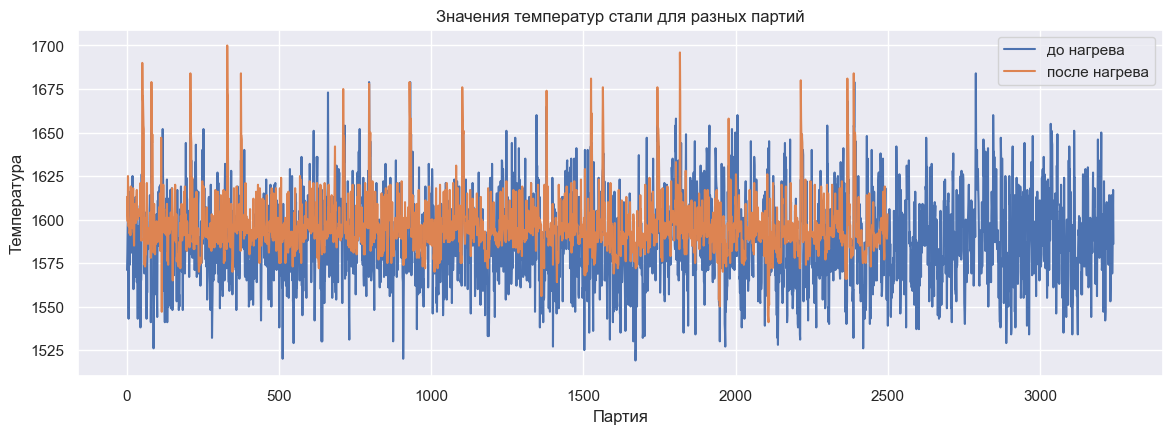

In [34]:
# построим значения температур для каждой партии
plt.figure(figsize=(14, 4.5))
plt.title('Значения температур стали для разных партий')

sns.lineplot(t_before, label='до нагрева')
sns.lineplot(t_after, label='после нагрева')

plt.ylabel('Температура')
plt.xlabel('Партия');

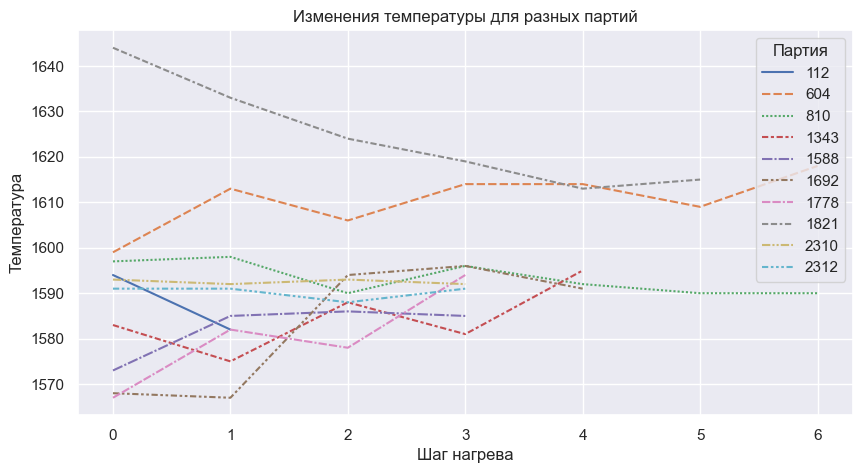

In [35]:
# построим изменения температур внутри случайных 10 партий (исключая партии только с одним измерением)
np.random.seed(RANDOM_STATE)

data = temperature_df[temperature_df.key.isin(np.random.randint(0, 2499, 10))].copy()
data['row_in_group'] = data.groupby('key').temperature.transform('cumcount')
data = data.rename(columns={'key': 'Партия'})

plt.figure(figsize=(10, 5))
sns.lineplot(data.pivot_table(columns='Партия', values='temperature', index='row_in_group'))

plt.title('Изменения температуры для разных партий');
plt.ylabel('Температура');
plt.xlabel('Шаг нагрева');

- среднее значение температуры до нагрева приблизительно на 6 градусов меньше среднего значения температуры после нагрева, однако распределение обладает большим стандартным отклонением. Распределение значений температуры после нагрева имеет меньший разброс и сложную структуру с 4 пиками и одним плечом со стороны меньших температур. Это может указывать на то, что распределение - композиция целевых температур для разных типов сплавов.
- со временем средние температуры не изменяются 

## Данные о подаче сыпучих материалов

In [36]:
# вывдем 5 случайных партий для датасета с объемом материалов
bulk_df.sample(5, random_state=RANDOM_STATE)

Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  \
key                                                                            
799      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2157     NaN     NaN    99.0    67.0     NaN     NaN     NaN     NaN     NaN   
2136     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
920      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2230     NaN     NaN     NaN   134.0     NaN     NaN     NaN     NaN     NaN   

      Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
key                                                         
799       NaN      NaN    205.0      NaN     99.0      NaN  
2157     61.0      NaN    329.0      NaN    196.0    190.0  
2136      NaN      NaN    273.0      NaN     93.0      NaN  
920       NaN      NaN    309.0      NaN    207.0    154.0  
2230      NaN      NaN    115.0      NaN    248.0    106.0

В разных партиях подаются разные сыпучие материалы, причем их кол-во сильно меньше кол-ва доступных материалов. Этим объясняется большое число пропусков в данных.

In [37]:
# выведем эти же партии для датасета со временем подачи материалов
bulk_time_df.sample(5, random_state=RANDOM_STATE)

Bulk 1 Bulk 2               Bulk 3               Bulk 4 Bulk 5 Bulk 6  \
key                                                                          
799     NaN    NaN                  NaN                  NaN    NaN    NaN   
2157    NaN    NaN  2019-07-29 12:00:10  2019-07-29 12:07:45    NaN    NaN   
2136    NaN    NaN                  NaN                  NaN    NaN    NaN   
920     NaN    NaN                  NaN                  NaN    NaN    NaN   
2230    NaN    NaN                  NaN  2019-07-31 20:52:01    NaN    NaN   

     Bulk 7 Bulk 8 Bulk 9              Bulk 10 Bulk 11              Bulk 12  \
key                                                                           
799     NaN    NaN    NaN                  NaN     NaN  2019-06-03 13:53:26   
2157    NaN    NaN    NaN  2019-07-29 12:15:00     NaN  2019-07-29 12:25:47   
2136    NaN    NaN    NaN                  NaN     NaN  2019-07-28 17:11:05   
920     NaN    NaN    NaN                  NaN     NaN  2019-06-08 02:36:55   
2230    NaN    NaN    NaN                  NaN     NaN  2019-07-31 20:59:02   

     Bulk 13              Bulk 14              Bulk 15  
key                                                     
799      NaN  2019-06-03 13:48:38                  NaN  
2157     NaN  2019-07-29 12:15:00  2019-07-29 12:07:45  
2136     NaN  2019-07-28 17:06:44                  NaN  
920      NaN  2019-06-08 02:23:41  2019-06-08 02:06:38  
2230     NaN  2019-07-31 20:52:01  2019-07-31 20:43:20

In [38]:
print('Заполнение ячеек в двух датафреймах совпадают:', bulk_df.isna().equals(bulk_time_df.isna()))

Заполнение ячеек в двух датафреймах совпадают: True


Как и ожидалось, в одном датафрейме приведен объем используемых в партии материалов, а во втором - время подачи соответствующего материала.

In [39]:
# выведем основную информацию по датасету
bulk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Bulk 1   252 non-null    float64
 1   Bulk 2   22 non-null     float64
 2   Bulk 3   1298 non-null   float64
 3   Bulk 4   1014 non-null   float64
 4   Bulk 5   77 non-null     float64
 5   Bulk 6   576 non-null    float64
 6   Bulk 7   25 non-null     float64
 7   Bulk 8   1 non-null      float64
 8   Bulk 9   19 non-null     float64
 9   Bulk 10  176 non-null    float64
 10  Bulk 11  177 non-null    float64
 11  Bulk 12  2450 non-null   float64
 12  Bulk 13  18 non-null     float64
 13  Bulk 14  2806 non-null   float64
 14  Bulk 15  2248 non-null   float64
dtypes: float64(15)
memory usage: 391.1 KB


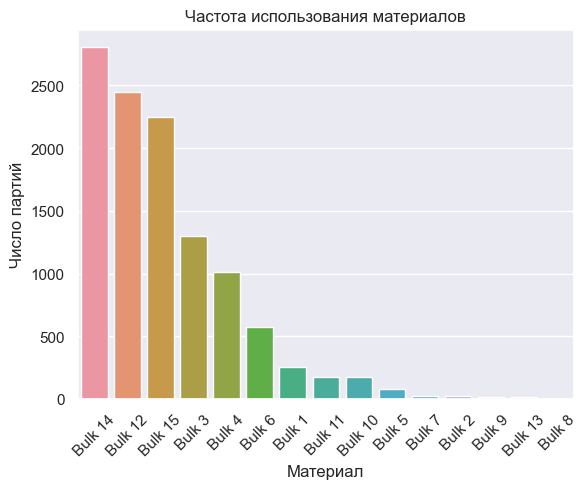

In [40]:
# частота использования различных материалов сильно отличается
# визуализируем число использований различных сыпучих материалов
freq_materials = (bulk_df.shape[0] - bulk_df.isna().sum()).reset_index().sort_values(0, ascending=False)\
                                                          .rename(columns={'index': 'Материал', 0: 'Число партий'})

sns.barplot(freq_materials, x='Материал', y='Число партий')
plt.title('Частота использования материалов')
plt.xticks(rotation=45);

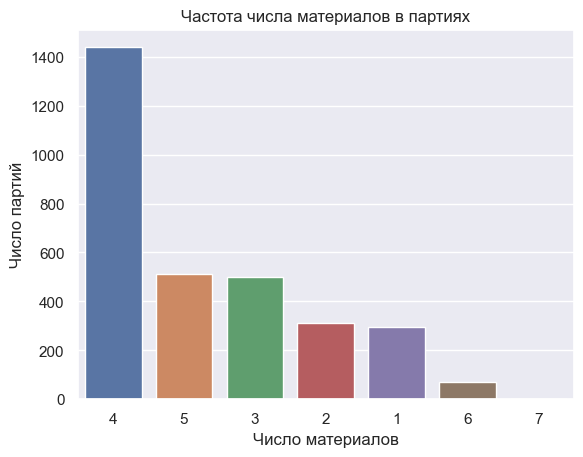

In [41]:
# посчитаем сколько в каждой партии было использовано сыпучих материалов и построим гистограмму частот 
data = (bulk_df.shape[1] - bulk_df.isna().sum(axis=1)).value_counts().reset_index()\
                                                      .rename(columns={'index': 'Число материалов', 0: 'Число партий'})\
                                                      .sort_values('Число партий', ascending=False)
sns.barplot(data, x='Число материалов', y='Число партий', order=data['Число материалов'])
plt.title('Частота числа материалов в партиях');

In [42]:
# выберем 6 чаще всего используемых материалов
most_freq_bulk = bulk_df[freq_materials.iloc[:6, 0].values]

# выведем для них описательные статитстики
most_freq_bulk.describe()

Bulk 14      Bulk 12      Bulk 15       Bulk 3       Bulk 4  \
count  2806.000000  2450.000000  2248.000000  1298.000000  1014.000000   
mean    170.284747   260.471020   160.513345   113.879045   104.394477   
std      65.868652   120.649269    51.765319    75.483494    48.184126   
min      16.000000    53.000000     1.000000     6.000000    12.000000   
25%     119.000000   204.000000   105.000000    58.000000    72.000000   
50%     151.000000   208.000000   160.000000    97.500000   102.000000   
75%     205.750000   316.000000   205.000000   152.000000   133.000000   
max     636.000000  1849.000000   405.000000   454.000000   281.000000   

           Bulk 6  
count  576.000000  
mean   118.925347  
std     72.057776  
min     17.000000  
25%     69.750000  
50%    100.000000  
75%    157.000000  
max    503.000000

In [43]:
print('Число аномально больших значений для Bulk 12:', (most_freq_bulk['Bulk 12'] > 750).sum())

Число аномально больших значений для Bulk 12: 5


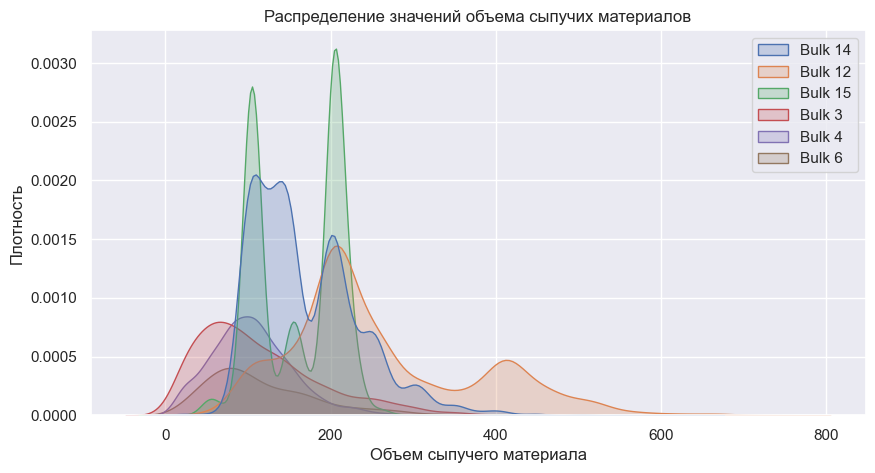

In [44]:
# построим распределение значений объема сыпучих материалов исключив аномальные значения Bulk 12
plt.figure(figsize=(10, 5))
sns.kdeplot(most_freq_bulk[most_freq_bulk < 750], fill=True)

plt.title('Распределение значений объема сыпучих материалов')
plt.ylabel('Плотность')
plt.xlabel('Объем сыпучего материала');

- в разных партиях состав подаваемых сыпучих материалов может быть разным
- чаще всего используются материалы под номерами 12, 14 и 15, крайне редко (<100 раз) используются материалы с номерами 2, 5, 7, 8, 9, 13
- чаще всего в сталь добавляется 4 сыпучих материала, обычно не более 5
- объем подаваемых сыпучих материалов сильно зависит от материала, распределения значений объема ненормальные, часто многопиковые

In [45]:
# приведем все названия колонок в соответствие с питоновским стилем
new_col_names = [col.replace(' ', '_').lower() for col in bulk_time_df.columns]
bulk_time_df.columns = new_col_names
bulk_df.columns = new_col_names

## Данные о подаче проволочных материалов

In [46]:
# выведем 5 случайных записей
wire_df.sample(5, random_state=RANDOM_STATE)

Wire 1     Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
key                                                                           
1131  103.053604        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2093   93.125755  15.170480     NaN     NaN     NaN     NaN     NaN     NaN   
1136   92.055603        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1137  125.143203        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3122  131.869919  72.745918     NaN     NaN     NaN     NaN     NaN     NaN   

      Wire 9  
key           
1131     NaN  
2093     NaN  
1136     NaN  
1137     NaN  
3122     NaN

Ситуация с данными похожа на ту, что была видна в предыдущем пункте.

In [47]:
# сравним два датафрейма объем и время
print('Заполнение ячеек в двух датафреймах совпадают:', wire_time_df.isna().equals(wire_df.isna()))

Заполнение ячеек в двух датафреймах совпадают: True


In [48]:
# выведем основную информацию по датасету
wire_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Wire 1  3055 non-null   float64
 1   Wire 2  1079 non-null   float64
 2   Wire 3  63 non-null     float64
 3   Wire 4  14 non-null     float64
 4   Wire 5  1 non-null      float64
 5   Wire 6  73 non-null     float64
 6   Wire 7  11 non-null     float64
 7   Wire 8  19 non-null     float64
 8   Wire 9  29 non-null     float64
dtypes: float64(9)
memory usage: 240.7 KB


In [49]:
# выведем описательные статистики
wire_df.describe()

Wire 1       Wire 2      Wire 3      Wire 4  Wire 5      Wire 6  \
count  3055.000000  1079.000000   63.000000   14.000000   1.000   73.000000   
mean    100.895853    50.577323  189.482681   57.442841  15.132   48.016974   
std      42.012518    39.320216   99.513444   28.824667     NaN   33.919845   
min       1.918800     0.030160    0.144144   24.148801  15.132    0.034320   
25%      72.115684    20.193680   95.135044   40.807002  15.132   25.053600   
50%     100.158234    40.142956  235.194977   45.234282  15.132   42.076324   
75%     126.060483    70.227558  276.252014   76.124619  15.132   64.212723   
max     330.314424   282.780152  385.008668  113.231044  15.132  180.454575   

          Wire 7      Wire 8     Wire 9  
count  11.000000   19.000000  29.000000  
mean   10.039007   53.625193  34.155752  
std     8.610584   16.881728  19.931616  
min     0.234208   45.076721   4.622800  
25%     6.762756   46.094879  22.058401  
50%     9.017009   46.279999  30.066399  
75%    11.886057   48.089603  43.862003  
max    32.847674  102.762401  90.053604

In [50]:
# построим распределение значений объема проволочных материалов 1 и 2 (наиболее часто используемых)
sns.kdeplot(wire_df[['Wire 1', 'Wire 2']], fill=True)
plt.title('Распределение значений объема проволочных материалов')
plt.ylabel('Плотность')
plt.xlabel('Объем проволочного материала');

- чаще всего используют материалы 1 и 2
- в среднем объем подаваемого материала 1 больше чем объем материала 2
- распределение значений объема материала 2 ненормальное со скосом вправо
- распределение значений объема материала 1 ненормальное со скосом влево

In [51]:
# приведем все названия колонок в соответствие с питоновским стилем
new_col_names = [col.replace(' ', '_').lower() for col in wire_time_df.columns]
wire_time_df.columns = new_col_names
wire_df.columns = new_col_names

## Данные о продувке сплава газом

In [52]:
gas_df.sample(5, random_state=RANDOM_STATE)

Газ 1
key            
1035   6.167195
992   11.541988
695   11.435276
943    4.144089
3074   9.858065

In [53]:
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Газ 1   3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


In [54]:
gas_df.describe()

Газ 1
count  3239.000000
mean     11.002062
std       6.220327
min       0.008399
25%       7.043089
50%       9.836267
75%      13.769915
max      77.995040

In [55]:
print('Число записей со значением больше 50:', gas_df[gas_df['Газ 1'] > 50].shape[0])

Число записей со значением больше 50: 5


In [56]:
sns.kdeplot(gas_df[gas_df['Газ 1'] < 50], fill=True)
plt.title('Распределение значений объема газа')
plt.ylabel('Плотность')
plt.xlabel('Объем газа');

- пропусков в данных нет, имеются аномально большие значения
- распределение значений объема газа имеет скос вправо

In [57]:
gas_df = gas_df.rename(
    columns={'Газ 1': 'gas_1'}
)

## Промежуточный вывод

- проверка временных данных показала, что процесс легирования выполнялся согласно описанным этапам последовательно. Временные данные в дальнейшем использоваться не будут
- наблюдается сильная корреляция активной и реактивной мощности, вместо них в дальнейшем будем использовать полную мощность
- в данных найдены аномалии которые необходимо будет удалить
- партии, для которых имеется только одна запись температуры далее не будут рассматриваться
- редко используемые материалы необходимо будет исключить из рассмотрения ввиду их малой "ценности"
- в качестве признака можно будет использовать только температуру до нагрева, промежуточные значения не рассматриваются

In [58]:
# удалим датасеты, которые не будем использовать
del bulk_time_df, wire_time_df

<font size="6" color="#61677A"><b>Часть 2: Код решения</b></font>

# Объединение таблиц

Сначала избавимся от аномалий в каждом датасете в отдельности, сагрегируем данные по партиям (таблицы по нагреву и температуре), сгенерируем новые фичи там, где это возможно. Для проверки корректности проделанных преобразований будем выводить head и tail, а также информацию о количестве записей и количестве колонок.

In [59]:
# данные с электродами: 

# удалим партии в которых присутствуют записи с очень маленькой отрицательной реактивной мощностью
keys_with_anomaly = electrode_df.query('reactive_power < 0').key.unique()
electrode_df = electrode_df[~electrode_df.key.isin(keys_with_anomaly)]

# агрегируем по партиям, берем среднее значение полной мощности и суммарное время нагрева, оставляем партии до номера 2500
electrode_df = electrode_df.pivot_table(index='key', values=['total_power', 'heating_time'], 
                                        aggfunc={'total_power': 'mean',  'heating_time': 'sum'})
electrode_df = electrode_df.loc[electrode_df.index < 2500, :]
electrode_df

heating_time  total_power
key                            
1           1098.0     0.743747
2            811.0     0.647087
3            655.0     1.003845
4            741.0     0.850010
5            869.0     0.704245
...            ...          ...
2495         723.0     0.967180
2496         940.0     0.845053
2497         569.0     1.453639
2498         750.0     0.781983
2499         883.0     0.542313

[2474 rows x 2 columns]

In [60]:
temperature_df

key    measurement_time  temperature
0         1 2019-05-03 11:02:04       1571.0
1         1 2019-05-03 11:07:18       1604.0
2         1 2019-05-03 11:11:34       1618.0
3         1 2019-05-03 11:18:04       1601.0
4         1 2019-05-03 11:25:59       1606.0
...     ...                 ...          ...
18087  3241 2019-09-06 16:55:01          NaN
18088  3241 2019-09-06 17:06:38          NaN
18089  3241 2019-09-06 17:21:48          NaN
18090  3241 2019-09-06 17:24:44          NaN
18091  3241 2019-09-06 17:30:05          NaN

[18092 rows x 3 columns]

In [61]:
df = temperature_df.pivot_table(index='key', values=['temperature', 'measurement_time'], 
                           aggfunc={'temperature': ['first', 'last'], 'measurement_time': ['first', 'last']})
df.columns = ['start_measurement_time', 'end_measurement_time', 'start_temperature', 'end_temperature']
df['measurement_time'] = (df['end_measurement_time'] - df['start_measurement_time']).dt.total_seconds()
df = df.drop(columns=['start_measurement_time', 'end_measurement_time'])
df

start_temperature  end_temperature  measurement_time
key                                                       
1                1571.0           1613.0            1714.0
2                1581.0           1602.0            1265.0
3                1596.0           1599.0            1753.0
4                1601.0           1625.0            1220.0
5                1576.0           1602.0            1536.0
...                 ...              ...               ...
3237             1569.0           1569.0            1470.0
3238             1584.0           1584.0            1102.0
3239             1598.0           1598.0            3185.0
3240             1617.0           1617.0            4205.0
3241             1586.0           1586.0            2470.0

[3216 rows x 3 columns]

In [62]:
# данные с измерениями температуры: 

# удаление партий с одним измерением, а также в которых есть записи с температурой менее 1500
keys_to_drop = np.concatenate([
    stages[stages['diff_nums'] != 1].index,
    temperature_df.query('key >= 2500').key.unique(),
    temperature_df.query('temperature < 1500').key.unique()
])

temperature_df = temperature_df[~temperature_df.key.isin(keys_to_drop)]

# агрегация по партиям, берем только первое и последнее измерения (как значение времени, так и температуры)
temperature_df = temperature_df.pivot_table(index='key', values=['temperature', 'measurement_time'], 
                                            aggfunc={'temperature': ['first', 'last'], 'measurement_time': ['first', 'last']})

temperature_df.columns = ['start_measurement_time', 'end_measurement_time', 'start_temperature', 'end_temperature']
temperature_df['measurement_time'] = (temperature_df['end_measurement_time'] - temperature_df['start_measurement_time']).dt.total_seconds()

temperature_df = temperature_df.drop(columns=['start_measurement_time', 'end_measurement_time'])
temperature_df

start_temperature  end_temperature  measurement_time
key                                                       
1                1571.0           1613.0            1714.0
2                1581.0           1602.0            1265.0
3                1596.0           1599.0            1753.0
4                1601.0           1625.0            1220.0
5                1576.0           1602.0            1536.0
...                 ...              ...               ...
2495             1570.0           1591.0            1380.0
2496             1554.0           1591.0            1705.0
2497             1571.0           1589.0             962.0
2498             1591.0           1594.0            1520.0
2499             1569.0           1603.0            1537.0

[2471 rows x 3 columns]

In [63]:
# данные с измерениями сыпучих материалов:

# выделим редко используемые материалы (использовались менее чем в 500 партиях)
RARE_THRESHOLD = 500
rare_materials = freq_materials[freq_materials['Число партий'] < RARE_THRESHOLD]['Материал'].apply(lambda x: x.lower().replace(' ', '_'))

# оставим партии до 2500 номера, заполним пропуски нулями, удалим редко используемые материалы
bulk_df = bulk_df.query('key < 2500').fillna(0).drop(rare_materials, axis=1)

# удалим запись с аномальным значением bulk 12 > 1000
bulk_df = bulk_df[bulk_df['bulk_12'] < 1000]
bulk_df

bulk_3  bulk_4  bulk_6  bulk_12  bulk_14  bulk_15
key                                                    
1        0.0    43.0     0.0    206.0    150.0    154.0
2        0.0    73.0     0.0    206.0    149.0    154.0
3        0.0    34.0     0.0    205.0    152.0    153.0
4        0.0    81.0     0.0    207.0    153.0    154.0
5        0.0    78.0     0.0    203.0    151.0    152.0
...      ...     ...     ...      ...      ...      ...
2495    21.0     0.0     0.0    256.0    129.0    223.0
2496     0.0    63.0     0.0    256.0    129.0    226.0
2497     0.0    85.0     0.0    230.0    124.0    226.0
2498    90.0     0.0     0.0    206.0    129.0    207.0
2499    47.0     0.0     0.0    233.0    126.0    227.0

[2407 rows x 6 columns]

In [64]:
# данные с проволочными материалами:

# из предварительного анализа данных мы видели, что часто используются только 1 и 2 проволочные материалы, остальные в менее чем 100 партиях
# поэтому оставим тоько эти два материала
# пропуски заполним нулями
wire_df = wire_df.query('key < 2500').fillna(0).drop(wire_df.columns.difference(['wire_1', 'wire_2']), axis=1)
wire_df

wire_1    wire_2
key                       
1      60.059998   0.00000
2      96.052315   0.00000
3      91.160157   0.00000
4      89.063515   0.00000
5      89.238236   9.11456
...          ...       ...
2495   89.150879   0.00000
2496  114.179527   0.00000
2497   94.086723   9.04800
2498  118.110717   0.00000
2499  110.160958  50.00528

[2373 rows x 2 columns]

In [65]:
# данные по продувке газом:

# необходимо только исключить из рассмотрения партии с номерами более 2499
gas_df = gas_df.query('key < 2500')
gas_df

gas_1
key            
1     29.749986
2     12.555561
3     28.554793
4     18.841219
5      5.413692
...         ...
2495   7.125735
2496   9.412616
2497   6.271699
2498  14.953657
2499  11.336151

[2497 rows x 1 columns]

In [66]:
# объединяем данные в одну таблицу. Ключ - номер партии, тип объединения - inner
merged_df = temperature_df.join([electrode_df, bulk_df, wire_df, gas_df], how='inner')
merged_df

start_temperature  end_temperature  measurement_time  heating_time  \
key                                                                        
1                1571.0           1613.0            1714.0        1098.0   
2                1581.0           1602.0            1265.0         811.0   
3                1596.0           1599.0            1753.0         655.0   
4                1601.0           1625.0            1220.0         741.0   
5                1576.0           1602.0            1536.0         869.0   
...                 ...              ...               ...           ...   
2495             1570.0           1591.0            1380.0         723.0   
2496             1554.0           1591.0            1705.0         940.0   
2497             1571.0           1589.0             962.0         569.0   
2498             1591.0           1594.0            1520.0         750.0   
2499             1569.0           1603.0            1537.0         883.0   

      total_power  bulk_3  bulk_4  bulk_6  bulk_12  bulk_14  bulk_15  \
key                                                                    
1        0.743747     0.0    43.0     0.0    206.0    150.0    154.0   
2        0.647087     0.0    73.0     0.0    206.0    149.0    154.0   
3        1.003845     0.0    34.0     0.0    205.0    152.0    153.0   
4        0.850010     0.0    81.0     0.0    207.0    153.0    154.0   
5        0.704245     0.0    78.0     0.0    203.0    151.0    152.0   
...           ...     ...     ...     ...      ...      ...      ...   
2495     0.967180    21.0     0.0     0.0    256.0    129.0    223.0   
2496     0.845053     0.0    63.0     0.0    256.0    129.0    226.0   
2497     1.453639     0.0    85.0     0.0    230.0    124.0    226.0   
2498     0.781983    90.0     0.0     0.0    206.0    129.0    207.0   
2499     0.542313    47.0     0.0     0.0    233.0    126.0    227.0   

          wire_1    wire_2      gas_1  
key                                    
1      60.059998   0.00000  29.749986  
2      96.052315   0.00000  12.555561  
3      91.160157   0.00000  28.554793  
4      89.063515   0.00000  18.841219  
5      89.238236   9.11456   5.413692  
...          ...       ...        ...  
2495   89.150879   0.00000   7.125735  
2496  114.179527   0.00000   9.412616  
2497   94.086723   9.04800   6.271699  
2498  118.110717   0.00000  14.953657  
2499  110.160958  50.00528  11.336151  

[2323 rows x 14 columns]

In [67]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2323 entries, 1 to 2499
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   start_temperature  2323 non-null   float64
 1   end_temperature    2323 non-null   float64
 2   measurement_time   2323 non-null   float64
 3   heating_time       2323 non-null   float64
 4   total_power        2323 non-null   float64
 5   bulk_3             2323 non-null   float64
 6   bulk_4             2323 non-null   float64
 7   bulk_6             2323 non-null   float64
 8   bulk_12            2323 non-null   float64
 9   bulk_14            2323 non-null   float64
 10  bulk_15            2323 non-null   float64
 11  wire_1             2323 non-null   float64
 12  wire_2             2323 non-null   float64
 13  gas_1              2323 non-null   float64
dtypes: float64(14)
memory usage: 272.2 KB


С данными всё неплохо, пропусков нет.

In [68]:
# удалим датафреймы которые в дальнейшем не будем использовать
del electrode_df,temperature_df, bulk_df, wire_df, gas_df

# Исследовательский анализ объединенных данных

Для начала построим распределения значений и ящики с усами для каждого признака.

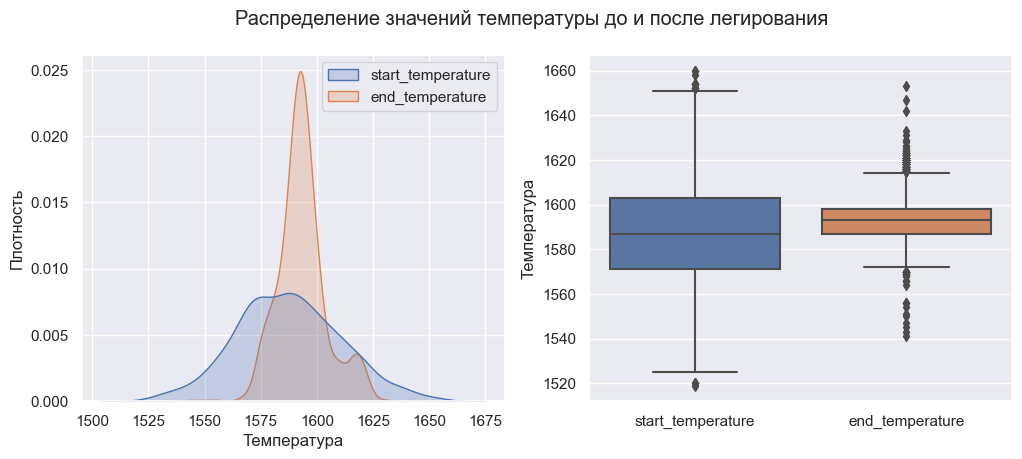

In [69]:
plt.figure(figsize=(12, 4.5))
plt.suptitle('Распределение значений температуры до и после легирования')

plt.subplot(1, 2, 1)
sns.kdeplot(merged_df.iloc[:, :2], fill=True)
plt.ylabel('Плотность')
plt.xlabel('Температура')

plt.subplot(1, 2, 2)
sns.boxplot(merged_df.iloc[:, :2])
plt.ylabel('Температура');

Из вида распределения температуры после легирования можно предположить, что всего существует три целевые температуры для разных типов стали.

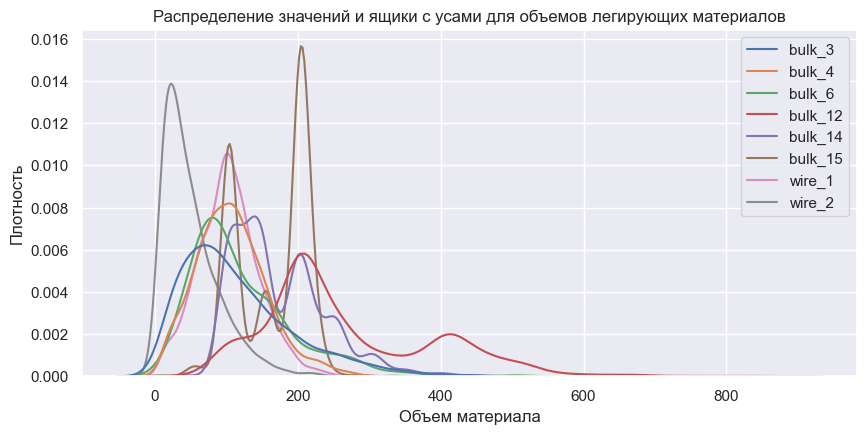

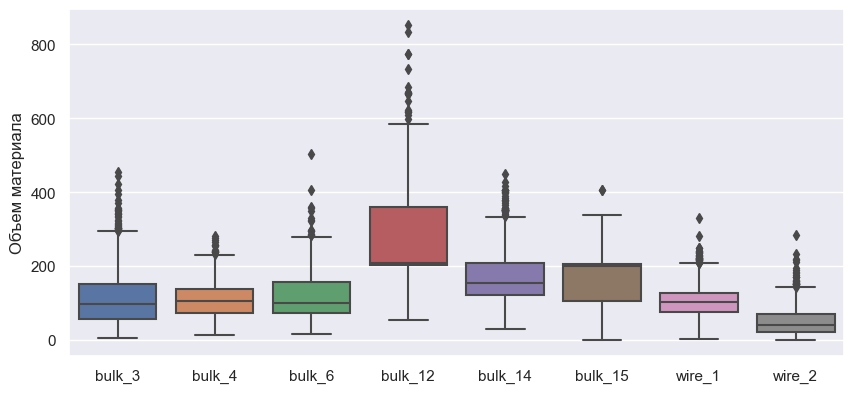

In [70]:
# для используемых материалов построим распределеня без случаев, когда значение объема равно нулю 
plt.figure(figsize=(10, 4.5))
sns.kdeplot(merged_df[merged_df > 0].iloc[:, 5:-1], common_norm=False)
plt.title('Распределение значений и ящики с усами для объемов легирующих материалов')
plt.ylabel('Плотность')
plt.xlabel('Объем материала')
plt.show()

plt.figure(figsize=(10, 4.5))
sns.boxplot(merged_df[merged_df > 0].iloc[:, 5:-1])
plt.ylabel('Объем материала')
plt.show()

Для каждого материала существуют свои характерные объемы для разных видов стали. Например для сыпучего материала №15 их 3, для материала №14 около 7. 

In [71]:
# функция для построения kdeplot и boxplot на одном графике
def plot_kde_box(s: pd.Series, title: str):
    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    plt.suptitle(title)
    
    sns.boxplot(x=s.values, ax=ax_box)
    sns.kdeplot(s, fill=True, ax=ax_hist)
    plt.xlabel(s.name.title().replace('_', ' '))
    
    plt.show()

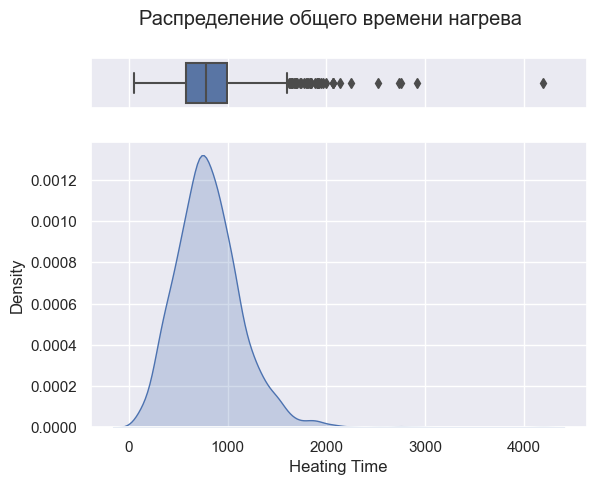

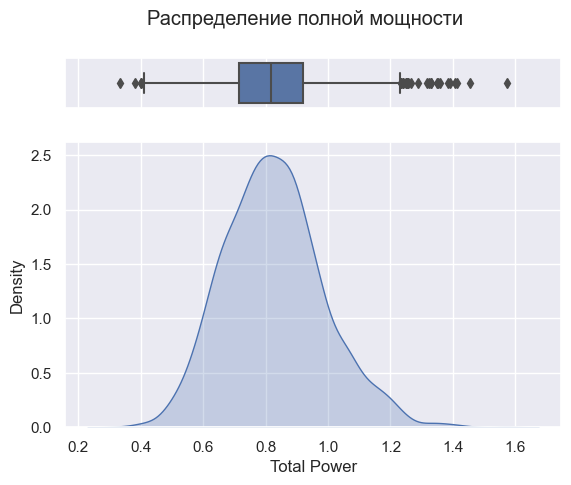

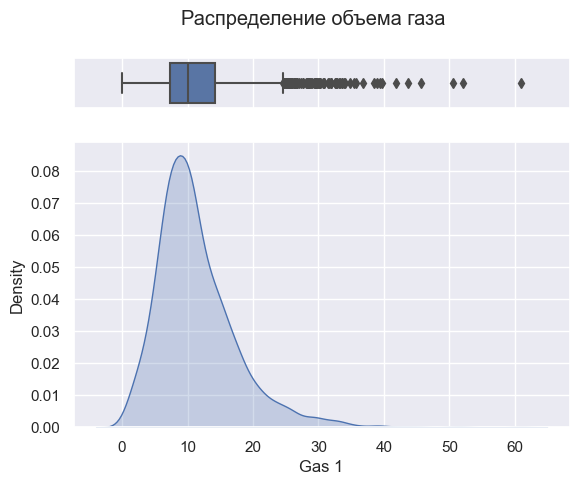

In [72]:
for col, title in zip(['heating_time', 'total_power', 'gas_1'], ['общего времени нагрева', 'полной мощности', 'объема газа']):
    plot_kde_box(merged_df[col], 'Распределение ' + title)

Распределения общего времени нагрева и объема газа имеют скос вправо и большие выбросы.

In [73]:
plt.figure(figsize=(10, 10))
plot_corr_heatmap(merged_df.corr(), 'Коэффициенты корреляции Пирсона')

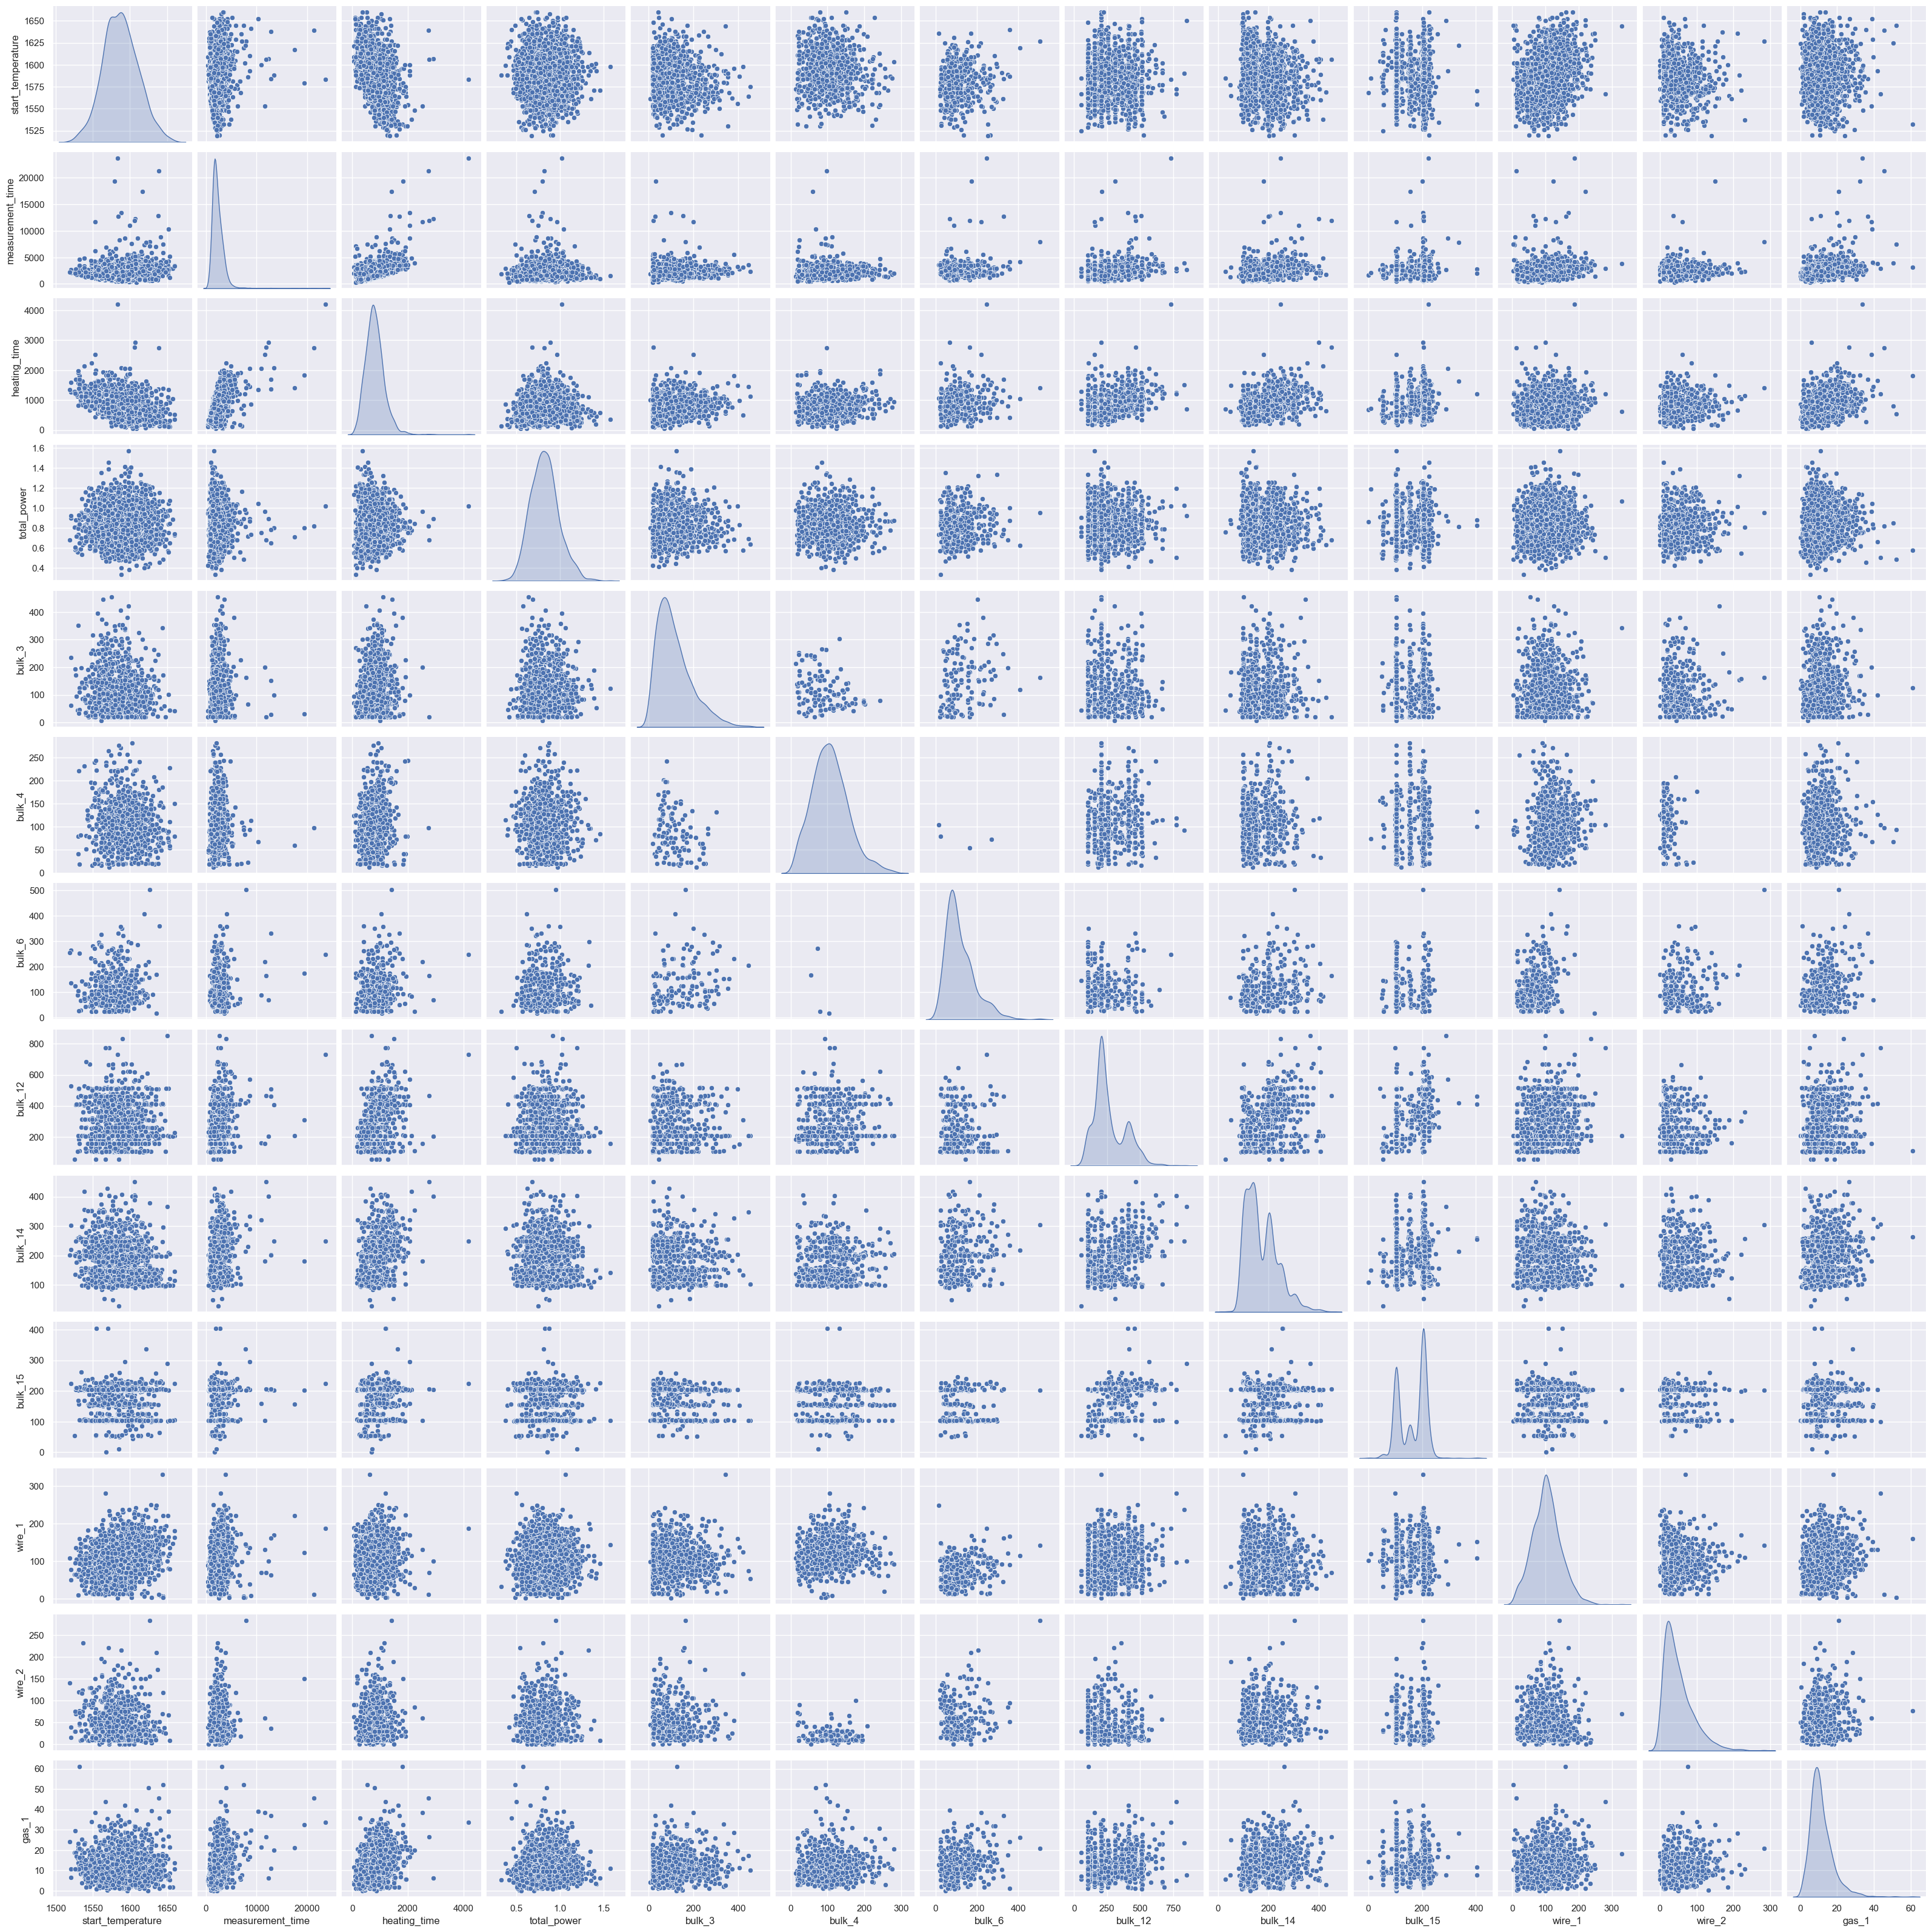

In [74]:
sns.pairplot(merged_df[merged_df > 0].drop('end_temperature', axis=1), diag_kind='kde');

Сильной корреляции признаков не наблюдается.

# Подготовка обучающей и тестовой выборок

In [75]:
X = merged_df.drop('end_temperature', axis=1)
y = merged_df['end_temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, shuffle=True)

print('Размер обучающей выборки:', X_train.shape[0])
print('Размер тестовой выборки:', X_test.shape[0])

Размер обучающей выборки: 1742
Размер тестовой выборки: 581


Две линейные модели обучим на двух датасетах. Первый датасет - как есть, без изменений, второй - обработка выбросов клипованием. За выброс будем считать значения меньше 3-го квантиля и больше 97-го квантиля.

In [76]:
Q_LOW = 0.03
Q_HIGH = 0.97

y_train_clipped = y_train.clip(y_train.quantile(Q_LOW), y_train.quantile(Q_HIGH))
X_train_clipped = X_train.clip(X_train.quantile(Q_LOW), X_train.quantile(Q_HIGH), axis=1)

# Обучение моделей

In [77]:
# сюда будем сохранять лучшие значения MAE на кросс-валидации для разных моделей
scores = pd.DataFrame(columns=['train_MAE'])

In [78]:
# функция для обучения модели с подборкой гиперпараметров и кросс-валидацией
def train_model(model, parameters, X, y, data_type=''):
    gscv = GridSearchCV(model, parameters, n_jobs=-1, cv=5, scoring='neg_mean_absolute_error', verbose=1, refit=True)
    gscv.fit(X, y)
    
    if gscv.best_params_:
        print('\nBest parameters:')
        for param_name, val in gscv.best_params_.items():
            print(f'{param_name}: {val}')
    
    estimator_name = gscv.best_estimator_.__class__.__name__
    
    if estimator_name == 'Pipeline':
        estimator_name = gscv.best_estimator_[-1].__class__.__name__
    
    data_type = ' + ' + data_type if data_type else ''
    
    # строим результаты сравнения истинных значений с предсказанными
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.5))
    ax.set_title(estimator_name + data_type)
    PredictionErrorDisplay.from_estimator(gscv.best_estimator_, X, y, kind="actual_vs_predicted", ax=ax, 
                                          random_state=RANDOM_STATE, subsample=1200)
    plt.text(0.2, 0.95, f'Train MAE: {-gscv.best_score_:.2f}', horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.7))
    plt.show()
    
    scores.loc[estimator_name + data_type] = [-gscv.best_score_]
    
    return gscv.best_estimator_

## Линейная регрессия

Для линейных моделей будем масштабировать признаки с использованием StandardScaler. Чтобы не допустить утечек создадим пайплайн.

In [79]:
l_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

l_reg_st = train_model(l_reg, {}, X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Fitting 5 folds for each of 1 candidates, totalling 5 fits


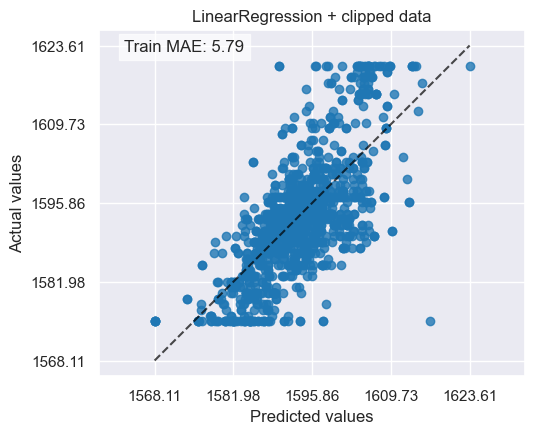

In [80]:
l_reg_clipped = train_model(l_reg, {}, X_train_clipped, y_train_clipped, 'clipped data')

Видно, что на "клиповых" данных получается добиться лучших результатов. На последующих моделях будем использовать именно эти данные.

## Случайный лес

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters:
max_depth: 10
n_estimators: 100


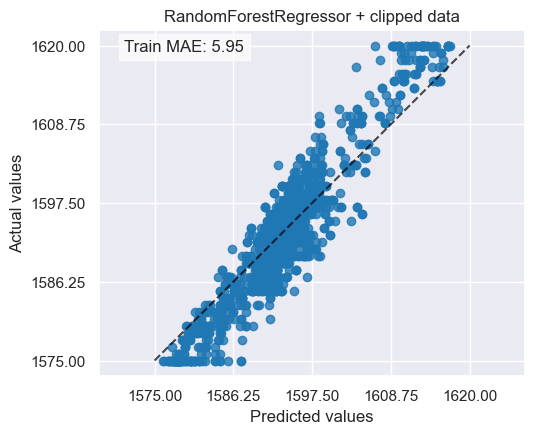

In [81]:
rf_reg = train_model(RandomForestRegressor(random_state=RANDOM_STATE), 
                     {'n_estimators': range(50, 301, 50), 'max_depth': range(2, 13, 2)}, 
                     X_train_clipped, y_train_clipped, 'clipped data')

## Градиентный бустинг

Рассмотрим два градиентных бустинга: CatBoost от Яндекса и LightGBM от Майкрософт.

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters:
max_depth: 2
n_estimators: 400


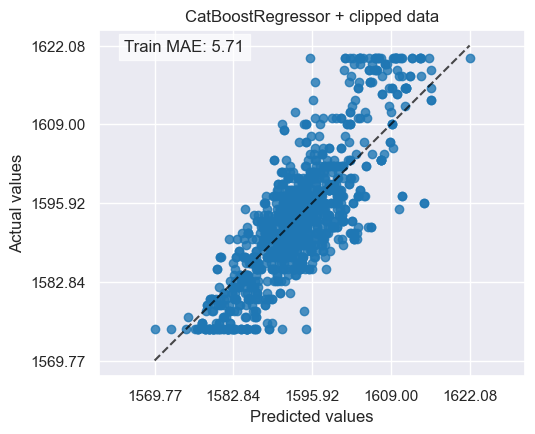

In [82]:
cat_reg = train_model(CatBoostRegressor(random_state=RANDOM_STATE, verbose=False),
                      {'n_estimators': range(200, 801, 200), 'max_depth': range(2, 9, 2)},
                      X_train_clipped, y_train_clipped, 'clipped data')

Fitting 5 folds for each of 56 candidates, totalling 280 fits

Best parameters:
max_depth: 4
n_estimators: 400


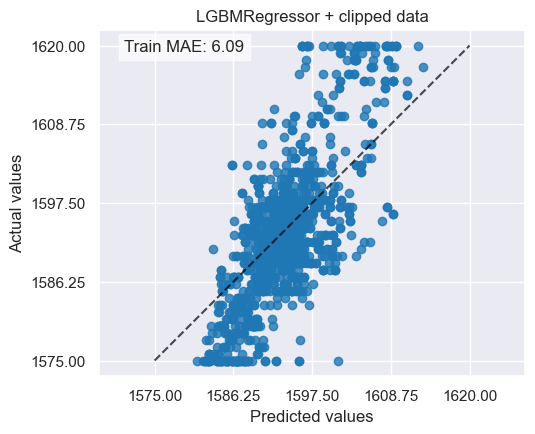

In [83]:
lgbm_reg = train_model(LGBMRegressor(random_state=RANDOM_STATE, 
                                     verbose=0, 
                                     force_col_wise=True, 
                                     learning_rate=0.01,
                                     num_leaves=5),
                       {'n_estimators': range(50, 401, 50), 
                        'max_depth': range(2, 9, 1)},
                        X_train_clipped, y_train_clipped, 'clipped data')

## Стекинг

Объединим лучший градиентный бустинг и случайный лес с уже подобранными гиперпараметрами и будем их использовать в качестве базовых моделей стекинга. Мета-моделью будет линейная регрессия. Поскольку поиск гиперпаметров для стекинга дело очень долгое, ограничимся только кросс-валидацией.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


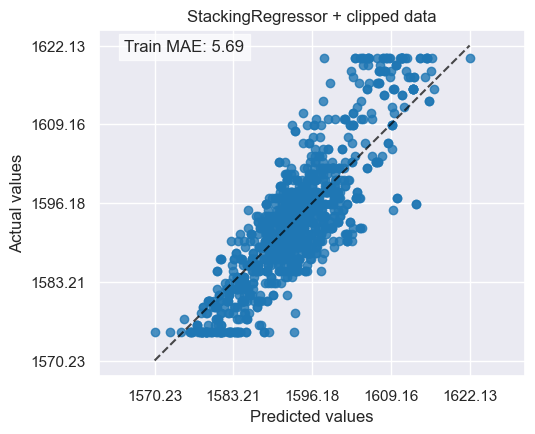

In [84]:
stack_reg = StackingRegressor(
    estimators=[
        ('RandomForest', rf_reg),
        ('CatBoost', cat_reg),
    ],
    final_estimator=LinearRegression(),
)

stack_reg_clipped = train_model(stack_reg, {}, X_train_clipped, y_train_clipped, 'clipped data')

## Промежуточный вывод

In [85]:
# выведем полученные метрики для всех обученных моделей
scores

train_MAE
LinearRegression                       6.012620
LinearRegression + clipped data        5.785109
RandomForestRegressor + clipped data   5.948277
CatBoostRegressor + clipped data       5.708881
LGBMRegressor + clipped data           6.093501
StackingRegressor + clipped data       5.693218

Стэкинг обладает лучшим результатом. Будем тестировать данную модель.

# Тестирование лучшей модели

In [86]:
# функция для тестирования лучшей модели
def test_best_model(model):
    # будем проводить сравнение с константной моделью
    dummy_reg = DummyRegressor()
    dummy_reg.fit(X_train_clipped, y_train_clipped)
    
    model_name = model.__class__.__name__
    model_test_mae = mean_absolute_error(y_test, model.predict(X_test))
    model_test_r2 = r2_score(y_test, model.predict(X_test))
    
    print(f'MAE on test data for {model_name}: {model_test_mae:.2f}')
    print(f'MAE on test data for Dummy model: {mean_absolute_error(y_test, dummy_reg.predict(X_test)):.2f}')
    print(f'R2 on test data for {model_name}: {model_test_r2:.2f}')
    
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.5))
    plt.title(model_name)
    PredictionErrorDisplay.from_estimator(model, X, y, kind="actual_vs_predicted", ax=ax, 
                                          random_state=RANDOM_STATE, subsample=1200)
    plt.text(0.2, 0.95, f'Test MAE: {model_test_mae:.2f}', horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.7))
    plt.show()

MAE on test data for StackingRegressor: 6.10
MAE on test data for Dummy model: 7.85
R2 on test data for StackingRegressor: 0.38


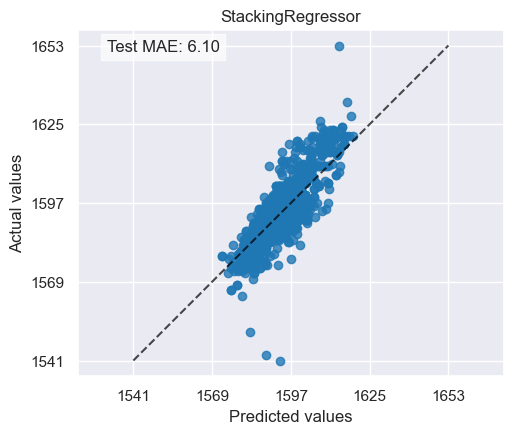

In [87]:
test_best_model(stack_reg_clipped)

Метрика на тестовых данных для стэкинга меньше, чем для констанной модели, и удовлетворяет заданному критерию MAE < 6.8. Метрика $R^2$ лежит в диапазоне от 0 до 1, что говорит об адекватности модели.

Посмотрим важность признаков для базовых моделей, затем посмотрим вклад каждой модели в итоговое предсказание.

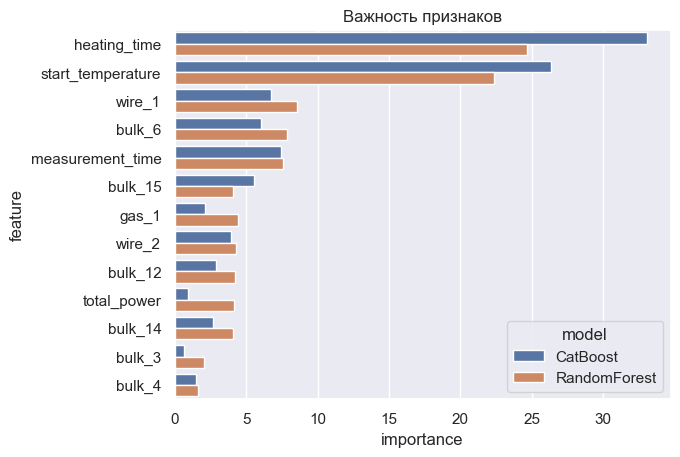

In [88]:
# строим важность признаков для базовых моделей стэкинга
feature_importances = pd.concat([pd.DataFrame({
        'feature': stack_reg_clipped.estimators_[0].feature_names_in_,
        'importance': stack_reg_clipped.estimators_[0].feature_importances_ * 100,
        'model': 'RandomForest'
    }),
    pd.DataFrame({
        'feature': stack_reg_clipped.estimators_[1].feature_names_,
        'importance': stack_reg_clipped.estimators_[1].feature_importances_,
        'model': 'CatBoost'
    })
]).sort_values('importance', ascending=False)

sns.barplot(y='feature', x='importance', data=feature_importances, hue='model', orient='h')
plt.title('Важность признаков');

Два самых важных признака, это:
1. время нагрева
2. начальная температура

Далее начинаются вариации важности признаков. В зависимости от модели порядок важности меняется; следующие три по важности признака:
- время измерения
- объем проволочного материала №1
- объем сыпучего материала №6

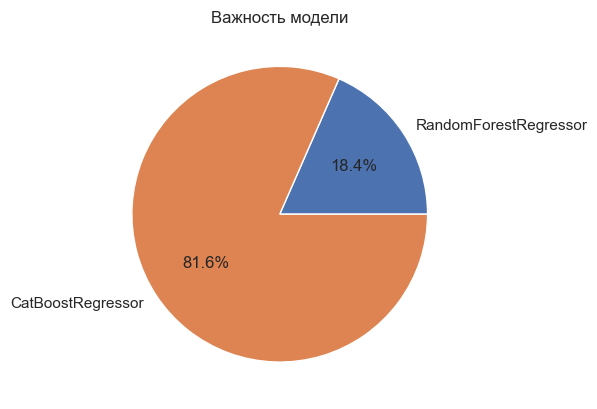

In [89]:
last_feature_importances = pd.DataFrame({
    'feature': map(lambda x: x.__class__.__name__, stack_reg_clipped.estimators_),
    'importance': stack_reg_clipped.final_estimator_.coef_
})

plt.pie(last_feature_importances.importance, labels=last_feature_importances.feature, autopct='%1.1f%%')
plt.title('Важность модели');

Больший вклад в итоговый ответ дает CatBoostRegressor.

# Вывод по второй части работы

Проведено объединение данных, признаки с большим числом пропусков удалены. Сгенерированы новые признаки: время нагрева, время измерения, среднее полной мощности. Проведенный корреляционный анализ показал, что используемые признаки слабо скоррелированы.

Выбросы в обучающих данных удалялись клипованием. Это позволило снизить MAE. Были обучены различные модели, лучшей из которых оказался стэкинг, в котором в качестве базовых моделей использовались RandomForest и CatBoost с уже подобранными ранее гиперпараметрами, а мета-моделью выступала линейная регрессия.

На тестовых данных удалось достигнуть требуемой метрики MAE < 6.8. Модель при этом адекватна. Наиболее важными признаками являются:
- время нагрева
- начальная температура
- время измерения
- объем проволочного материала №1
- объем сыпучего материала №6

<font size="6" color="#61677A"><b>Часть 3: Отчет</b></font>

# Сравнение решения и плана

Решение проекта полностью соответствует составленному плану работы: 
- в пункте 7 проведено удаление партий с аномалиями для всех датасетов, агрегация данных по ключу для датасетов с нагревом и температурой, объединение всех датасетов (кроме времени загрузки сыпучих материалов и проволочных материалов) по ключу
- в пункте 8 проведены исследовательский и корреляционный анализ данных
- в пункте 9 проведены разделение данных на тестовую и обучающую выборки, а также обработка выбросов в обучающей выборке: было использовано клипование, границами выступали 3й и 97й квантили
- в пункте 10 обучены различные модели, подобраны гиперпараметры, выбрана лучшая по метрике MAE
- в пункте 11 построен проведено тестирование лучшей модели, а также исследована важность признаков

# Трудности проекта

Поскольку на вебинаре были крайне подробно рассмотрены все аспекты и подводные камни проекта, особенных трудностей в процессе решения не возникло. Уже на первых итерациях удалось добиться требуемого MAE, который составлял около 6.5С. Небольшая трудность возникла при попытках улучшения метрики, путем генерации дополнительных фичей (хорошей дополнительной фичой оказалось время измерения, на начальном этапе мной рассматривалось только время нагрева) и выборе базовых моделей для модели стэкинга.

# Ключевые шаги решения

1. Первоначальный исследовательский анализ данных: позволил выявить основные аномалии и ошибки в датасетах, понять в каких датасетах нужно будет применять агрегирование данных, также позволил определить наименее важные фичи (которые редко встречаются в партиях)
2. Объединение данных: шаг очень важен, поскольку в нем можно легко допустить ошибки при объединении такого большого количества таблиц. Ключевым было объединение по номерам партий, которые присутсвуют во всех таблицах (INNER)
3. Корреляционный анализ: позволил убедиться в отсутствии сильной корреляции признаков, тем самым было получено обоснование для использования линейных моделей
4. Клипование выбросов в обучающей выборке и использование стэкинга: позволило получить лучшую метрику MAE

# Использованные признаки и их предобработка

In [93]:
print('Использованные признаки в порядке их важности на основе базовой модели CatBoost:')
feature_importances.query('model == "CatBoost"').sort_values('importance', ascending=False).drop('model', axis=1)

Использованные признаки в порядке их важности на основе базовой модели CatBoost:


feature  importance
2        heating_time   33.053155
0   start_temperature   26.306830
1    measurement_time    7.412829
10             wire_1    6.762385
6              bulk_6    6.069218
9             bulk_15    5.585461
11             wire_2    3.928681
7             bulk_12    2.894322
8             bulk_14    2.682603
12              gas_1    2.154750
5              bulk_4    1.511622
3         total_power    0.951291
4              bulk_3    0.686852

Пропуски в данных по объемам сыпучих материалов и проволочных материалов были заполнены нулями. Полная мощность рассчитывалась как корень из суммы квадратов активной и реактивной мощностей. Время нагрева - сумма всех интервалов нагрева стали. Время измерения - разность между первым измерением до начала нагрева и последним нагревом после окончания процесса легирования.

Для всех признаков в обучающей выборке выполнялось:
- клипование по границам 3го и 97го квантиля
- масштабирование признаков с помощью z-преобразования для линейных моделей

# Итоговая модель

По результатам сравнения метрик на кросс-валидации лучшей моделью оказался стэкинг с базовыми моделями CatBoost и RandomForest, для которых были заданы гиперпараметры полученные при их обучении по отдельности, и мета-моделью LinearRegression. 

In [107]:
# выведем основные гиперпараметры базовых моделей стэкинга
for estimator_name, estimator in stack_reg_clipped.get_params()['estimators']:
    print(estimator_name, end='\n')
    print('-' * 30)
    for name, value in estimator.get_params().items():
        print(f'{name}: {value}')
    print()

RandomForest
------------------------------
bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: 10
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 280823
verbose: 0
warm_start: False

CatBoost
------------------------------
loss_function: RMSE
verbose: False
max_depth: 2
n_estimators: 400
random_state: 280823



In [110]:
# выведем основные гиперпараметры мета-модели
for name, value in stack_reg_clipped.get_params()['final_estimator'].get_params().items():
    print(f'{name}: {value}')

copy_X: True
fit_intercept: True
n_jobs: None
positive: False


In [111]:
# итоговые метрики на тесте
print(f'Test MAE: {mean_absolute_error(y_test, stack_reg_clipped.predict(X_test)):.2f}')
print(f'Test R2: {r2_score(y_test, stack_reg_clipped.predict(X_test)):.2f}')

Test MAE: 6.10
Test R2: 0.38


Итоговая модель адекватна и удовлетворяет требованию MAE < 6.8. 